# Target Identification with AIDO.Cell

Here, we prioritize targets for Crohn's disease and Ulcerative Colitis through an in-silico transcriptome-wide knockout study with AIDO.Cell, and compare against a traditional differential expression analysis.

For installation, see the quickstart tutorial.

__Requirements__:
- A100 GPU or equivalent
- [ModelGenerator](https://genbio-ai.github.io/ModelGenerator/) installed
- ModelGenerator.experiments.AIDO.Cell requirements installed

### Mise en Place

This dataset contains 3 conditions
- **HC**: Healthy Controls
- **CD**: Crohn's Disease
- **UC**: Ulcerative Colitis

In [1]:
%%bash
# A dataset from GEO with Crohn's disease, Ulcerative Colitis, and healthy control samples
cd ~/ModelGenerator/experiments/AIDO.Cell
mkdir -p data
cd data
wget -O GSE214695.tar -nv 'http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE214695&format=file'
tar -xvf GSE214695.tar
cd ..

2025-04-03 21:35:52 URL:http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE214695&format=file [887091200/887091200] -> "GSE214695.tar" [1]


GSM6614348_HC-1_barcodes.tsv.gz
GSM6614348_HC-1_features.tsv.gz
GSM6614348_HC-1_matrix.mtx.gz
GSM6614349_HC-2_barcodes.tsv.gz
GSM6614349_HC-2_features.tsv.gz
GSM6614349_HC-2_matrix.mtx.gz
GSM6614350_HC-3_barcodes.tsv.gz
GSM6614350_HC-3_features.tsv.gz
GSM6614350_HC-3_matrix.mtx.gz
GSM6614351_HC-4_barcodes.tsv.gz
GSM6614351_HC-4_features.tsv.gz
GSM6614351_HC-4_matrix.mtx.gz
GSM6614352_HC-5_barcodes.tsv.gz
GSM6614352_HC-5_features.tsv.gz
GSM6614352_HC-5_matrix.mtx.gz
GSM6614353_HC-6_barcodes.tsv.gz
GSM6614353_HC-6_features.tsv.gz
GSM6614353_HC-6_matrix.mtx.gz
GSM6614354_UC-1_barcodes.tsv.gz
GSM6614354_UC-1_features.tsv.gz
GSM6614354_UC-1_matrix.mtx.gz
GSM6614355_UC-2_barcodes.tsv.gz
GSM6614355_UC-2_features.tsv.gz
GSM6614355_UC-2_matrix.mtx.gz
GSM6614356_UC-3_barcodes.tsv.gz
GSM6614356_UC-3_features.tsv.gz
GSM6614356_UC-3_matrix.mtx.gz
GSM6614357_UC-4_barcodes.tsv.gz
GSM6614357_UC-4_features.tsv.gz
GSM6614357_UC-4_matrix.mtx.gz
GSM6614358_UC-5_barcodes.tsv.gz
GSM6614358_UC-5_features.tsv

In [1]:
import os
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
from glob import glob

# Gather a single adata from all batches
adatas = []
for condition in ['HC', 'UC', 'CD']:
    for i in range(1, 7):
        file = glob(f'data/*_{condition}-{i}_matrix.mtx.gz')[0]
        dir_name = os.path.dirname(file)
        file_name = os.path.basename(file)
        prefix = file_name.split('matrix')[0]
        adata = sc.read_10x_mtx(dir_name, prefix=prefix)
        adata.obs['subject'] = f'{condition}-{i}'
        adata.obs['condition'] = condition
        sc.pp.filter_cells(adata, min_genes=500)
        sc.pp.filter_genes(adata, min_cells=3)
        adatas.append(adata)
adata = ad.concat(adatas, axis=0, join='outer', fill_value=0.0)
adata.obs_names_make_unique()
adata.var_names_make_unique()
print(adata.shape)

(46476, 22821)


/home/caleb_ellington_genbio_ai/miniforge3/envs/mgen/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
# Save an unnormalized copy for AIDO.Cell for later
adata_copy = adata.copy()

### Preliminary Data Analysis

In [3]:
# Normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Clustering + UMAP
sc.pp.neighbors(adata)
sc.tl.leiden(adata, flavor='igraph', n_iterations=2, resolution=0.5)
sc.tl.umap(adata)

# Marker gene sets
gene_sets = {
    'epithelial_cells': ['EPCAM', 'AQP8', 'BEST4', 'MUC2', 'OLFM4', 'PLCG2', 'TRPM5', 'ZG16'],
    'b_and_plasma_cells': ['CD79A', 'BANK1', 'CD19', 'DERL3', 'MS4A1', 'MZB1'],
    't_cells': ['CD3D', 'CD3E', 'CD3G', 'CD8A', 'FOXP3', 'GZMA', 'GZMB', 'IL17A', 'NKG7', 'TRBC1'],
    'stromal_cells': ['ACTA2', 'ADAMDEC1', 'CHI3L1', 'COL3A1', 'NRXN1', 'PVALP', 'SOX6', 'VWF'],
    'myeloid_cells': ['AIF1', 'C1QA', 'C1QB', 'CD14', 'CMTM2', 'FCGR3B', 'LYZ', 'MS4A2', 'TPSAB1', 'TPSAB2'],
}

# Score based on markers
gene_pool = []
for cur_set in gene_sets:
    gene_pool.extend(gene_sets[cur_set])
for cur_set in gene_sets:
    sc.tl.score_genes(adata, gene_sets[cur_set], score_name='score_'+cur_set, gene_pool=gene_pool)

/home/caleb_ellington_genbio_ai/miniforge3/envs/mgen/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 22821 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/home/caleb_ellington_genbio_ai/miniforge3/envs/mgen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


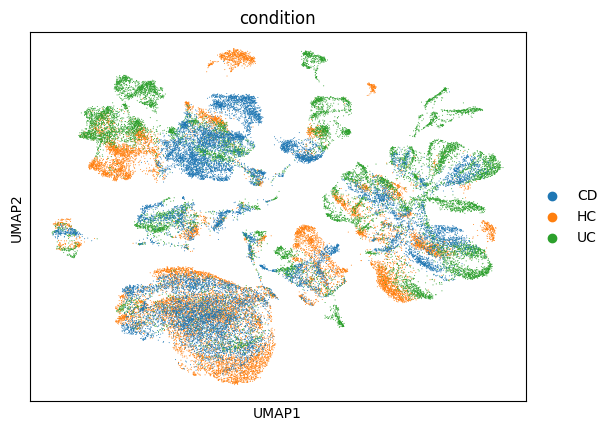

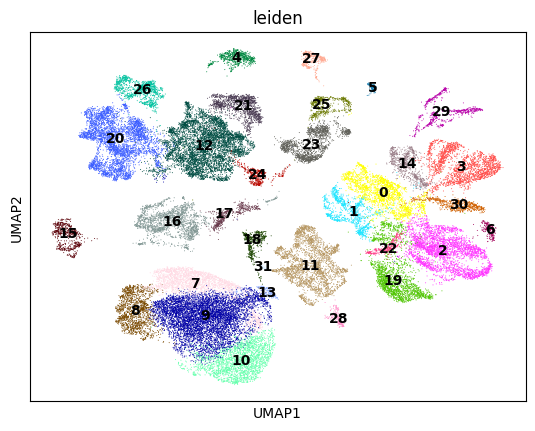

In [4]:
sc.pl.umap(
    adata,
    color='condition',
    size=2,
)
sc.pl.umap(
    adata,
    color='leiden',
    size=2,
    legend_loc='on data'
)

### Focus on epithelial cells, a known cell-type for this disease

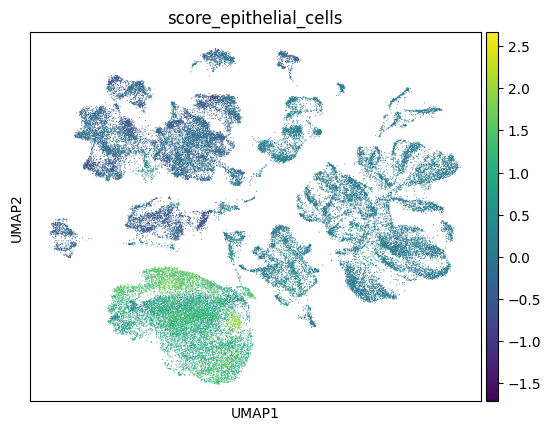

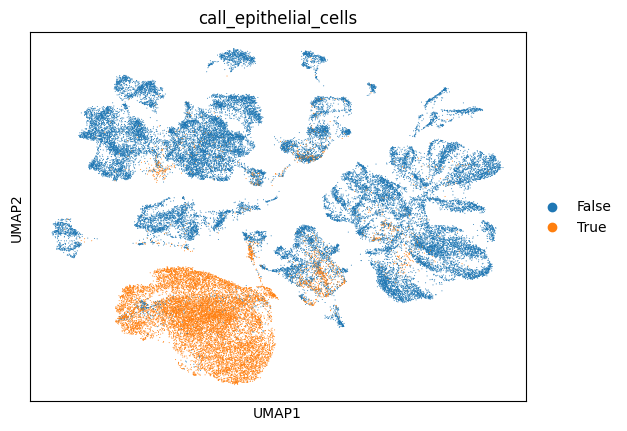

In [5]:
sc.pl.umap(
    adata,
    color=('score_epithelial_cells'),
    size=2,
)
adata.obs['call_epithelial_cells'] = adata.obs['score_epithelial_cells'] > 1.5 * np.mean(adata.obs['score_epithelial_cells'])
sc.pl.umap(
    adata,
    color=('call_epithelial_cells'),
    size=2,
)

### Moving on to target ID, we'll focus on the main cluster of high-scoring epithelial cells 

In [6]:
epithelial_clusters = ['7', '8', '9', '10']  # Leiden clusters from above

## Traditional Target ID with Differential Expression

To compare with AIDO.Cell, we perform a traditional differential expression analysis.

Below shows the top 25 most differentially expressed genes relative to healthy controls.

In [22]:
# Compute DE genes for CD/UC relative to HC: 
epithelial_adata = adata[adata.obs['leiden'].isin(['7', '8', '9', '10'])]
sc.tl.rank_genes_groups(epithelial_adata, groupby='condition', groups=['HC', 'CD'], reference='HC')
de_df = sc.get.rank_genes_groups_df(epithelial_adata, group='CD')
de_df = de_df.sort_values('pvals_adj').reset_index(drop=True)

# Filter out mitochondrial and ribosomal genes
de_df = de_df[~de_df['names'].str.contains('^MT-|^RPL|^RPS')]
de_df.reset_index(drop=True, inplace=True)
de_df.head(25)

/home/caleb_ellington_genbio_ai/miniforge3/envs/mgen/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:669: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


,names,scores,logfoldchanges,pvals,pvals_adj
0,LCN2,61.971252,4.036991,0.000000e+00,0.000000e+00
1,CYBA,55.507397,2.868275,0.000000e+00,0.000000e+00
2,PLA2G2A,53.727989,2.889512,0.000000e+00,0.000000e+00
3,CD74,49.467701,2.478950,0.000000e+00,0.000000e+00
4,MTRNR2L1,-45.837566,-2.455476,0.000000e+00,0.000000e+00
5,C19orf33,-44.503468,-1.815585,0.000000e+00,0.000000e+00
6,MUC1,47.974728,1.970692,0.000000e+00,0.000000e+00
7,DMBT1,42.205254,3.418359,0.000000e+00,0.000000e+00
8,OLFM4,41.832394,3.938372,0.000000e+00,0.000000e+00
9,PHGR1,41.017372,1.811534,0.000000e+00,0.000000e+00


### A known target, SOX4, comes in very very low

In [23]:
de_df[de_df['names'] == 'SOX4']

,names,scores,logfoldchanges,pvals,pvals_adj
6067,SOX4,-3.400045,-0.17753,0.000676,0.002516


## Target ID with AIDO.Cell

Here we do an in-silico transcriptome-wide knockout study with AIDO.Cell.

We rank targets based on their knockout's ability to push the cell towards the healthy control state.

In [9]:
# Preprocess the unnormalized adata copy for AIDO.Cell
import cell_utils
adata_aligned, attention_mask = cell_utils.align_adata(adata_copy)

###########  Aligning data to AIDO.Cell  ###########
AIDO.Cell was pretrained on a fixed set of 19264 genes.
Aligning your data to the AIDO.Cell gene set...
6695 in your data that cannot be used by AIDO.Cell. Removing these.
['A1BG-AS1' 'A2M-AS1' 'AAED1' ... 'ZNRF3-AS1' 'ZRANB2-AS1' 'ZSCAN16-AS1']
3138 genes in the AIDO.Cell pretraining set missing in your data.
AIDO.Cell is trained with zero-masking. Setting these to zero for AIDO.Cell to ignore.
['A2ML1' 'A3GALT2' 'A4GNT' ... 'ZSCAN5C' 'ZSWIM2' 'ZZZ3']
16126 non-zero genes remaining.
Reordering genes to match AIDO.Cell gene ordering
Gathering attention mask for nonzero genes
####################  Finished  ####################


In [10]:
# Requires A100 or larger GPU
import torch
from tqdm import tqdm
import numpy as np
from modelgenerator.tasks import Embed

device = 'cuda:0'
batch_size = 4
model = Embed.from_config({
        "model.backbone": "aido_cell_3m",
        "model.batch_size": batch_size
    }).eval()
model = model.to(device).to(torch.bfloat16)

/home/caleb_ellington_genbio_ai/miniforge3/envs/mgen/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
def extract_features(adata):
    # Extracts embedding features batchwise from adata and returns a compiled mean-pooled embedding for each cell
    emb_list = []
    num_batches = int(np.ceil(adata.shape[0] / batch_size))
    for k in tqdm(range(num_batches)):
        idx_start = k * batch_size
        idx_stop = (k+1) * batch_size
        batch_np = adata[idx_start:idx_stop].X.toarray()
        batch_tensor = torch.from_numpy(batch_np).to(torch.bfloat16).to(device)
        batch_transformed = model.transform({'sequences': batch_tensor})
        with torch.no_grad():
            embs = model(batch_transformed)
        emb_list.extend(embs.mean(axis=1).cpu().to(torch.float16).numpy())
    return np.array(emb_list)


def ko_embs(adata, idx_list):
    # Performs in-silico knockout on every gene and returns the resulting embeddings using the above function
    embs = {}
    for count, i in enumerate(idx_list):
        print(f'gene {count+1} / {len(idx_list)}')
        cur_gene = adata.var.index[i]
        adata_ko = adata.copy()
        adata_ko[:, i] = 0.0
        embs[cur_gene] = extract_features(adata_ko)
    return embs

### Embed Healthy Controls

In [12]:
adata_hc = adata_aligned[(adata_aligned.obs['condition'] == 'HC') & (adata.obs['leiden'].isin(['7', '8', '9', '10']))]
embs_hc = extract_features(adata_hc)

  0%|          | 0/1590 [00:00<?, ?it/s]/home/caleb_ellington_genbio_ai/ModelGenerator/modelgenerator/tasks/tasks.py:1667: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.long).to(self.device)
/home/caleb_ellington_genbio_ai/ModelGenerator/modelgenerator/backbones/backbones.py:672: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(
100%|██████████| 1590/1590 [00:57<00:00, 27.80it/s]


### Embed Disease Cells with Simulated Knockouts

In [ ]:
adata_cd = adata_aligned[(adata_aligned.obs['condition'] == 'CD') & (adata.obs['leiden'].isin(['7', '8', '9', '10']))]

# Subsample cells:
num_ss = 500
ss_rng = np.random.default_rng(1234)
idx_rand = np.sort(ss_rng.permutation(adata_cd.shape[0])[:num_ss])
adata_cd = adata_cd[idx_rand, :]

# Choose gene set:
# Currently limiting to genes that are expressed in >= 50% of cells; 
# If we're going to set a gene to zero, population won't change much if it's usually zero anyway. 
min_frac_expr = 0.5 
pert_genes_idx = np.ravel(np.argwhere(np.ravel(adata_cd.X.sum(axis=0)) > min_frac_expr * adata_cd.shape[0]))
pert_gene_names = adata_cd.var.index[pert_genes_idx]

# This takes ~3h on a single H100. 
# Go make some coffee, read a paper, clean your house.
ko_embs_cd = ko_embs(adata_cd, pert_genes_idx)

In [15]:
pert_gene_names = adata_cd.var.index[pert_genes_idx] 

### Score genes based on embedding distance from knockout to healthy control population

In [19]:
# Compute distance to healthy control embedding
hc_emb = embs_hc.mean(axis=0)
dist = []
for cur_idx in pert_genes_idx:
    cur_gene_name = adata_aligned.var.index[cur_idx]
    pert_emb = ko_embs_cd[cur_gene_name].mean(axis=0)
    dist.append(np.mean((pert_emb - hc_emb)**2))

# Genes by distance
dist = np.array(dist)
pert_genes_idx_srt = np.argsort(dist)
dist_srt = dist[pert_genes_idx_srt]
pert_gene_names_srt = pert_gene_names[pert_genes_idx_srt]
target_df = pd.DataFrame({'gene': pert_gene_names_srt, 'distance': dist_srt})
target_df = target_df[~target_df['gene'].str.contains('^MT-|^RPL|^RPS')]
target_df.reset_index(inplace=True, drop=True)

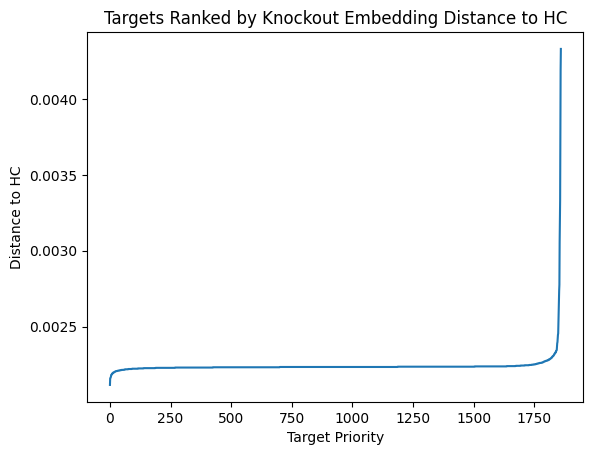

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.sort(dist))
plt.xlabel('Target Priority')
plt.ylabel('Distance to HC')
plt.title('Targets Ranked by Knockout Embedding Distance to HC')
plt.show()

### AIDO.Cell scores the known target SOX4 as a top target

In [21]:
target_df.head(25)

,gene,distance
0,SPINK1,0.002115
1,ATP5F1E,0.002169
2,CLDN3,0.002180
3,ITM2C,0.002182
4,PLA2G2A,0.002182
5,ATP5F1D,0.002188
6,CLCA1,0.002192
7,CA1,0.002192
8,ATP5ME,0.002193
9,ATP5F1B,0.002197


### SOX4 comes in at rank 13, vs. rank 6067 from differential expression analysis